# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### yali.gal@runi.ac.il, liel.huri@runi.ac.il, nimros.boazi@runi.ac.il

---
---


In [93]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
NumPy version: 2.3.4


# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

### Algorithm Description

**AdaBoost** is an ensemble learning method that combines multiple weak learners to create a strong classifier.

#### Mathematical Formulation:

**Input**: 
- $\ell$: loss function
- $\alpha$: learning rate parameter (computed per iteration)
- $\{(x_i, y_i)\}$: training dataset with $n$ samples
- $A$: **weak learner algorithm** - the method that trains weak classifiers

In our implementation, $A$ is implemented using sklearn's `DecisionTreeClassifier` with `max_depth=1` (a decision stump), which:
- Searches over all features and thresholds
- Finds the single split that minimizes $\sum_{i:h(x_i)\neq y_i} w_i$
- Returns the best decision stump as the weak learner $h$

**Algorithm**:

1. **Initialize**: 
   - $H_0 = 0$
   - $\forall i : w_i = \frac{1}{n}$ (uniform weight initialization)

2. **For** $t = 0$ to $T-1$ **do**:
   - $h = \arg\min_h \sum_{i:h(x_i)\neq y_i} w_i$ which is computed as $h = A((w_1, x_1, y_1), \ldots, (w_n, x_n, y_n))$
   - In other words: train weak learner using algorithm $A$ with weighted samples
   - $\epsilon = \sum_{i:h(x_i)\neq y_i} w_i$ ⟹ Calculate weighted error
   - **if** $\epsilon < \frac{1}{2}$ **then**:
     - $\alpha = \frac{1}{2} \ln\left(\frac{1-\epsilon}{\epsilon}\right)$ ⟹ Calculate classifier weight
     - $H_{t+1} = H_t + \alpha h$ ⟹ Add weighted classifier to ensemble
     - $\forall i : w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$ ⟹ Update sample weights
   - **else**:
     - **return** $(H_t)$ ⟹ Stop if weak learner fails
   - **end**

3. **end**

4. **Return**: $H_T = \sum_{t=0}^{T-1} \alpha_t h_t$ (final strong classifier)

**Prediction**: $\text{sign}(H_T(x))$

### Key Properties:

- **Adaptive Weighting**: Weight update $w_i \leftarrow w_i e^{-\alpha h(x_i)y_i}$ increases weights for misclassified samples
- **Sequential Training**: Each weak learner $h$ focuses on samples with high weights

### Critical Condition:

- **Weak Learner Requirement**: $\epsilon < 0.5$ (must be better than random guessing)
- If $\epsilon \geq 0.5$, algorithm terminates early

### Limitations:

1. **Sensitive to Noise**: Noisy/mislabeled examples get exponentially high weights
2. **Outlier Amplification**: Outliers that are consistently misclassified dominate training
3. **Binary Classification**: Original formulation requires $y_i \in \{-1, +1\}$

### Implementation Details:

- **Weak Learner $A$**: Decision stumps (1-level decision trees) - simple, fast, interpretable
- **Weight Update**: Exact formula $w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$ from pseudocode
- **Vectorization**: NumPy operations for computational efficiency

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

1. **Weak Learner Algorithm $A$ (Decision stump via `DecisionTreeClassifier(max_depth=1)`)**:
   - **What it represents**: $A$ is the algorithm that trains weak classifiers from weighted data
   - **Mathematical goal**: Implements $h = A((w_1,x_1,y_1), \ldots, (w_n,x_n,y_n))$ to find $h = \arg\min_h \sum_{i:h(x_i)\neq y_i} w_i$
   - **How it works**: 
     - Takes weighted samples $(w_i, x_i, y_i)$ as input in the `fit(X, y, weights)` method
     - Returns decision stump $h$ with minimum weighted error
   - **Output**: A trained weak classifier (decision stump) that can predict labels via $h(x)$

2. **Weight Initialization**:
   - Initialize equal weights for all samples: $\forall i : w_i = \frac{1}{n}$

3. **Error Calculation**:
   - Calculate weighted classification error of h : $\epsilon = \sum_{i:h(x_i)\neq y_i} w_i$

4. **Alpha Calculation**:
   - Adaptive step size: $\alpha = \frac{1}{2} \ln\left(\frac{1-\epsilon}{\epsilon}\right)$

5. **Weight Update**:
   - Calculating new weights: $w_i \leftarrow \frac{w_i e^{-\alpha h(x_i)y_i}}{2\sqrt{\epsilon(1-\epsilon)}}$

6. **Stopping Condition**:
   - If the learner is not better than guessing then stop, otherwise continue to next iteration: **if** $\epsilon < \frac{1}{2}$ **then** continue, **else** return

7. **Final Hypothesis**:
   - The final strong classifier built from a weighted combination of several weak classifiers: $H_T = \sum_{t=0}^{T-1} \alpha_t h_t$


In [94]:
# Your code here
# Part 1: Implementing AdaBoost


class AdaBoostCustom:
    def __init__(self, T):
        """
        Args:
            T: Number of iterations (weak learners)
            A: Weak learner algorithm (default: DecisionTreeClassifier with max_depth=1)
        """
        self.T = T
        self.alphas = [] 
        self.models = []  
        self.train_errors = []
        self.weights_history = []
        
    def fit(self, X, y):
        """
        Train the AdaBoost classifier with O(T) efficiency for error tracking
        and numerically stable weight updates.
        
        Args:
            X: Feature matrix (n_samples, n_features)
            y: Labels (must be {-1, +1})
        """
        n_samples = X.shape[0]
        
        # Reset state for a fresh fit
        self.models = []
        self.alphas = []
        self.train_errors = []
        self.weights_history = []  # reset weight history

        # 1. Initialize weights uniformly
        weights = np.ones(n_samples) / n_samples        
        
        # 2. Initialize array to track cumulative scores for training error
        self.running_train_scores = np.zeros(n_samples)
        
        for t in range(self.T):
            # 3. Train weak learner
            h = DecisionTreeClassifier(max_depth=1, random_state=42)
            h.fit(X, y, sample_weight=weights)
            
            # Get predictions
            predictions = h.predict(X)
            
            # 4. Calculate weighted error
            incorrect = predictions != y
            epsilon = np.sum(weights[incorrect])
            
            # Avoid division by zero / log(0)
            epsilon = np.clip(epsilon, 1e-10, 1 - 1e-10)
            
            # Stop if the learner is no better than random guessing
            if epsilon >= 0.5:
                break
            
            # 5. Calculate alpha
            alpha = 0.5 * np.log((1 - epsilon) / epsilon)
            
            self.alphas.append(alpha)
            self.models.append(h)
            
            # 6. Update weights (numerically stable)
            weights = weights * np.exp(-alpha * y * predictions)
            weights /= np.sum(weights)  # normalize by actual sum

            # store current normalized weights for analysis/plots
            self.weights_history.append(weights.copy())
            
            # 7. Efficient training error calculation
            # Update running scores with current iteration's contribution
            self.running_train_scores += alpha * predictions
            
            # Get current ensemble predictions (sign of the sum)
            current_train_preds = np.where(self.running_train_scores >= 0, 1, -1)
            
            train_error = np.mean(current_train_preds != y)
            self.train_errors.append(train_error)

        
    def predict(self, X):
        """
        Make predictions using the ensemble H_T = ∑_{t=0}^{T-1} α_t h_t.
        
        Args:
            X: Feature matrix (n_samples, n_features)
            
        Returns:
            predictions: Array of predictions {-1, +1}
        """
        H_T = np.zeros(X.shape[0])
        
        for alpha, h in zip(self.alphas, self.models):
            H_T += alpha * h.predict(X)
        
        # Return sign, with ties broken as +1 (consistent with AdaBoost convention)
        return np.where(H_T >= 0, 1, -1)
    
    def predict_proba(self, X):
        """
        Return H_T(x) scores (before taking sign).
        Useful for plotting decision boundaries.
        """
        H_T = np.zeros(X.shape[0])
        for alpha, h in zip(self.alphas, self.models):
            H_T += alpha * h.predict(X)
        return H_T

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

## Dataset Choice for Initial Demonstration

### Dataset: Linearly Separable Classification Problem

We generate a synthetic dataset with the following properties:

1. **Binary Classification**: Two classes with labels {0, 1} (converted to {-1, +1})
2. **Moderate Complexity**: 2 informative features for visualization
3. **Moderate Sample Size**: 10000 samples for reliable training
4. **Class Balance**: Equal number of samples from each class

### Why This is Appropriate:

- **Interpretability**: 2D visualization allows us to see decision boundaries
- **Well-Suited for AdaBoost**: The problem benefits from combining multiple simple decision boundaries
- **Not Too Easy**: Requires multiple weak learners to achieve good performance

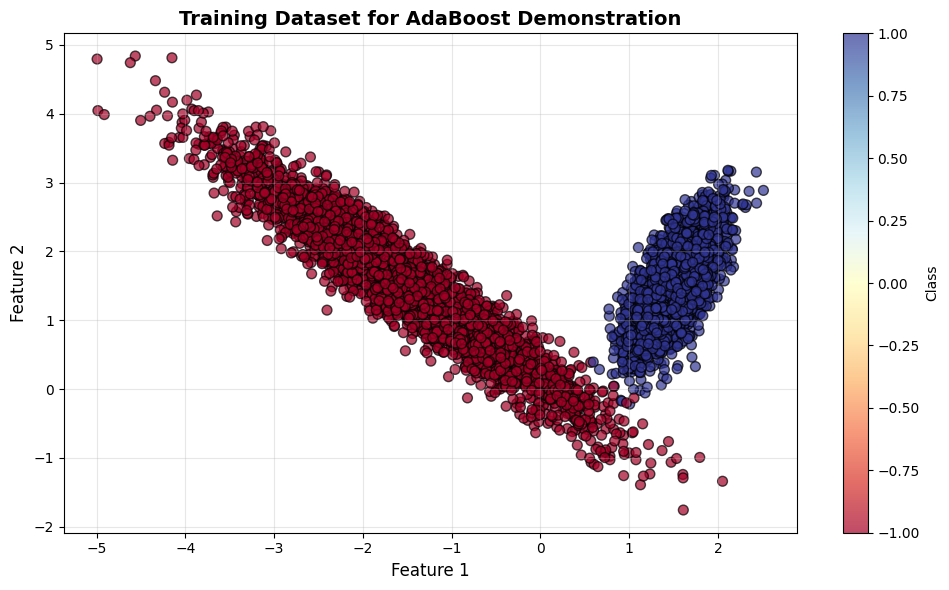

In [95]:
# Your code here
# Generate synthetic dataset for initial demonstration
X, y = make_classification(
    n_samples=10000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0,  
    class_sep=1.5,
    random_state=42
)
# Convert labels to {-1, +1} format required by AdaBoost
y = np.where(y == 0, -1, y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


# Visualize the dataset
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, 
                     cmap='RdYlBu', edgecolors='black', alpha=0.7, s=50)
plt.colorbar(scatter, label='Class')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Training Dataset for AdaBoost Demonstration', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

## Comparison: Custom vs. Sklearn Implementation (Nimi's Job)

### Expected Results:

### Key Differences from Sklearn:

- **Multi-class**: Our implementation is binary only; sklearn supports multi-class
- **Optimization**: Sklearn has C++/Cython optimizations; ours is pure NumPy
- **Feature Importance**: Sklearn tracks feature importance; we don't explicitly compute it

### Evaluation Metrics:

- **Accuracy**: Overall correctness on train/test sets
- **Training Error Curve**: Should decrease monotonically (verify no overfitting)
- **Decision Boundaries**: Visualization of learned classification regions
- **Performance Gap**: Difference between custom and sklearn should be minimal

Training Custom AdaBoost...
Training Sklearn AdaBoost...

PERFORMANCE COMPARISON
Custom AdaBoost  - Train Accuracy: 0.9973, Test Accuracy: 0.9963
Sklearn AdaBoost - Train Accuracy: 0.9973, Test Accuracy: 0.9963
Difference in test accuracy: 0.0000


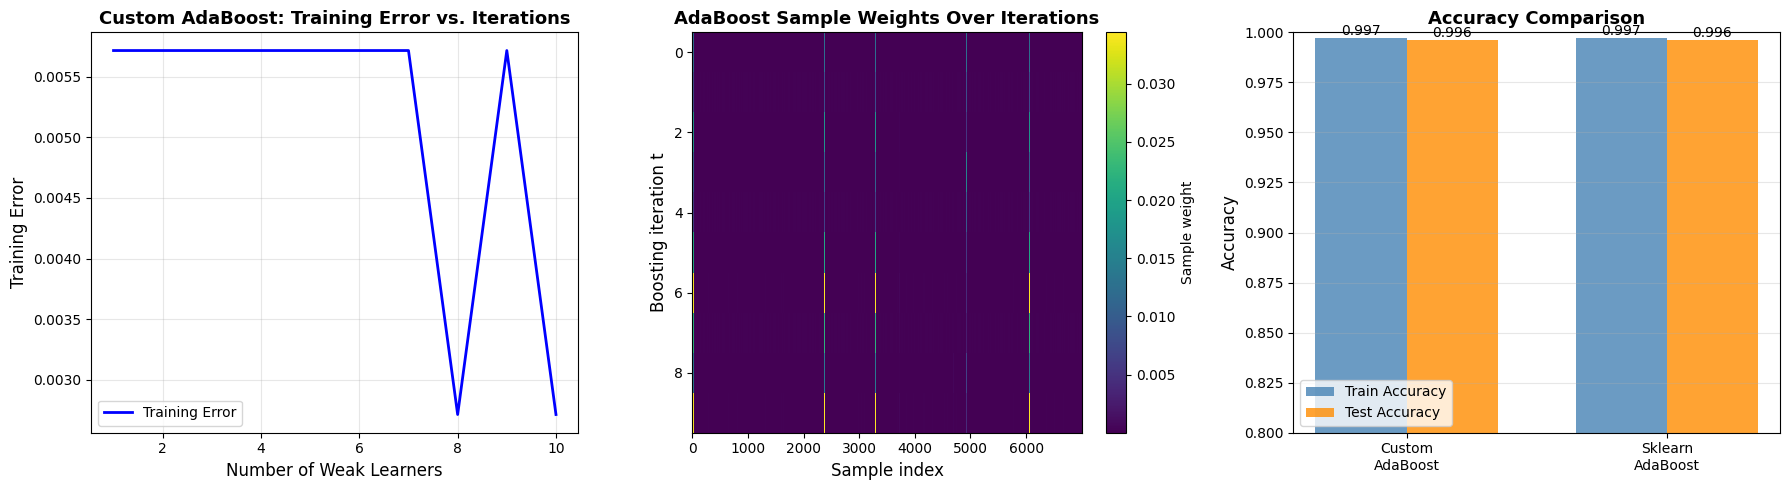

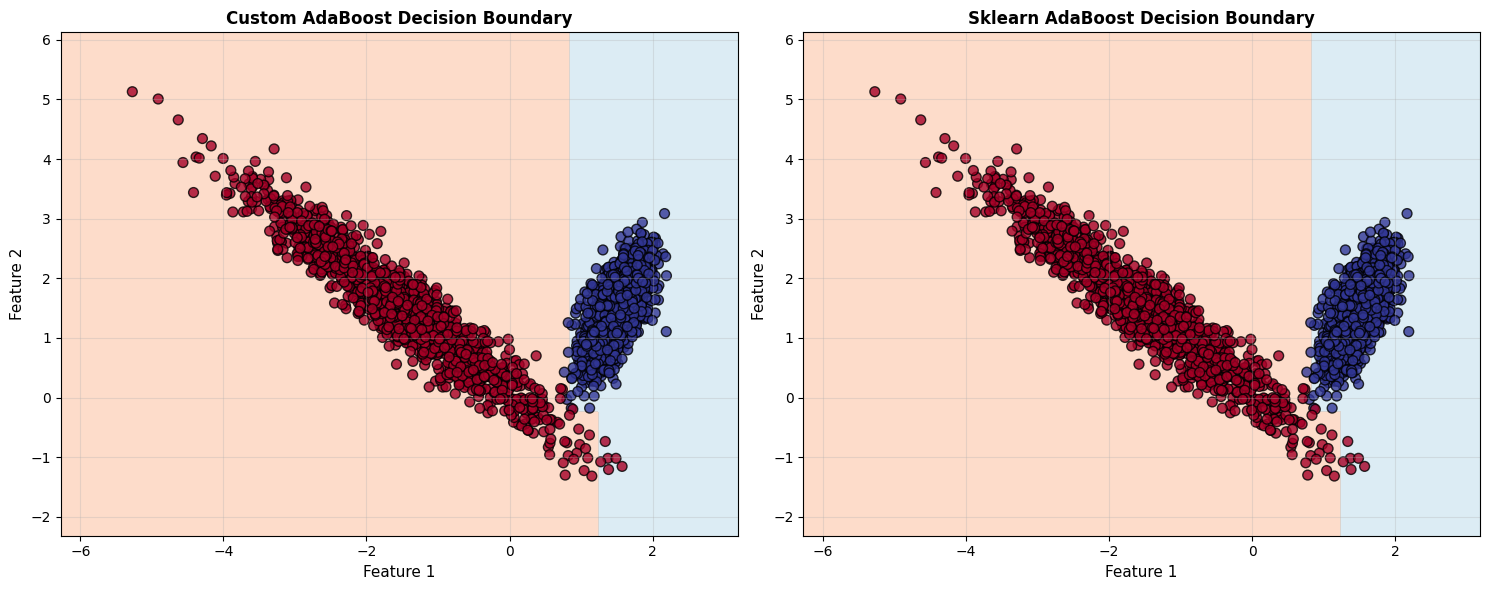

[np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.005714285714285714), np.float64(0.0027142857142857142), np.float64(0.005714285714285714), np.float64(0.0027142857142857142)]


In [96]:
# Train both models
n_estimators = 70

# custom_model = AdaBoostCustom(T=n_estimators)
# sklearn_model = AdaBoostClassifier(
#     estimator=DecisionTreeClassifier(max_depth=1),
#     n_estimators=n_estimators,
#     random_state=42
# )
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Fit models
print("Training Custom AdaBoost...")
custom_model.fit(X_train, y_train)
print("Training Sklearn AdaBoost...")
sklearn_model.fit(X_train, y_train)

# Make predictions
custom_pred_train = custom_model.predict(X_train)
custom_pred_test = custom_model.predict(X_test)
sklearn_pred_train = sklearn_model.predict(X_train)
sklearn_pred_test = sklearn_model.predict(X_test)

# Calculate accuracies (all labels and predictions are in {-1, +1} format)
custom_train_acc = accuracy_score(y_train, custom_pred_train)
custom_test_acc = accuracy_score(y_test, custom_pred_test)
sklearn_train_acc = accuracy_score(y_train, sklearn_pred_train)
sklearn_test_acc = accuracy_score(y_test, sklearn_pred_test)

# Print results
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Custom AdaBoost  - Train Accuracy: {custom_train_acc:.4f}, Test Accuracy: {custom_test_acc:.4f}")
print(f"Sklearn AdaBoost - Train Accuracy: {sklearn_train_acc:.4f}, Test Accuracy: {sklearn_test_acc:.4f}")
print(f"Difference in test accuracy: {abs(custom_test_acc - sklearn_test_acc):.4f}")
print("="*60)

# Visualization 1: Training error and weight evolution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Custom model training curve
axes[0].plot(range(1, len(custom_model.train_errors) + 1), 
             custom_model.train_errors, 'b-', linewidth=2, label='Training Error')
axes[0].set_xlabel('Number of Weak Learners', fontsize=12)
axes[0].set_ylabel('Training Error', fontsize=12)
axes[0].set_title('Custom AdaBoost: Training Error vs. Iterations', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Sample weight evolution heatmap
W = np.stack(custom_model.weights_history)  # shape: (T_used, n_samples)
im = axes[1].imshow(W, aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(im, ax=axes[1], label='Sample weight')
axes[1].set_xlabel('Sample index', fontsize=12)
axes[1].set_ylabel('Boosting iteration t', fontsize=12)
axes[1].set_title('AdaBoost Sample Weights Over Iterations', fontsize=13, fontweight='bold')

# Bar chart comparison
models = ['Custom\nAdaBoost', 'Sklearn\nAdaBoost']
train_scores = [custom_train_acc, sklearn_train_acc]
test_scores = [custom_test_acc, sklearn_test_acc]

x = np.arange(len(models))
width = 0.35

bars1 = axes[2].bar(x - width/2, train_scores, width, label='Train Accuracy', alpha=0.8, color='steelblue')
bars2 = axes[2].bar(x + width/2, test_scores, width, label='Test Accuracy', alpha=0.8, color='darkorange')

axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models)
axes[2].legend()
axes[2].set_ylim([0.8, 1.0])
axes[2].grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Visualization 2: Decision boundaries
def plot_decision_boundary(model, X, y, title, ax, is_custom=True):
    """Plot decision boundary for a classifier."""
    h = 0.02  # Step size in the mesh
    
    # Create mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predict on mesh (both models output {-1, +1})
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points)
    Z = Z.reshape(xx.shape)
    
    # Plot (contourf works with any numeric values)
    ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=[-1.5, 0, 1.5])
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                        edgecolors='black', s=50, alpha=0.8)
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_decision_boundary(custom_model, X_test, y_test, 
                      'Custom AdaBoost Decision Boundary', axes[0])
plot_decision_boundary(sklearn_model, X_test, y_test, 
                      'Sklearn AdaBoost Decision Boundary', axes[1])
plt.tight_layout()
plt.show()

print(custom_model.train_errors)

## Analysis
- Non monotonic fluctuations in training error reflect AdaBoost’s reweighting dynamics.
- The weight heatmap shows that only a small number of samples accumulate high weights across iterations, these samples correspond to borderline or difficult points near the class boundary.
- Both the custom and sklearn AdaBoost models learn a clean, well separated decision boundary.
- Only a minor accuracy gap between the train and test accuracy for both models.
- Zero difference in test accuracy between custom and sklearn AdaBoost confirms the correctness of the custom implementation.

# Generate additional data sets
## Experimental Datasets for AdaBoost Properties

### Dataset 1: Noisy Data - Testing Robustness

**Purpose**: Demonstrate AdaBoost's sensitivity to label noise.

**Design**:
- Base: Linearly separable classes
- Add **20% label noise** by randomly flipping labels
- This simulates real-world data where labels may be incorrect

**Expected Behavior**:
- AdaBoost will focus heavily on noisy points (misclassified examples)
- These points get high weights, leading to potential overfitting
- Performance gap between train and test sets should be larger than clean data

**Mathematical Formulation**:
For a fraction $p$ of samples, we flip: $y_i \leftarrow -y_i$

---

### Dataset 2: Non-Linear Data - Testing Capacity

**Purpose**: Demonstrate AdaBoost's ability to learn non-linear decision boundaries.

**Design**:
- **Two Moons** dataset - canonical non-linear problem
- Requires combining multiple linear decision boundaries
- Tests AdaBoost's capacity to build complex classifiers from simple stumps

**Expected Behavior**:
- Decision stumps alone cannot separate the moons
- Multiple stumps should create a piece-wise linear approximation
- Shows how boosting builds complexity

**Why These Datasets**:
1. **Noise Dataset**: Tests a known weakness of AdaBoost
2. **Non-linear Dataset**: Shows the strength of ensemble learning
3. **Complementary**: One shows limitations, one shows strengths

In [97]:
# Generate additional data sets

# Dataset 1: Noisy data
np.random.seed(42)
X_noisy, y_noisy = make_classification(
    n_samples=10000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.2,  # 20% label noise
    class_sep=1.5,
    random_state=42
)
# Convert labels to {-1, +1} format required by AdaBoost
y_noisy = np.where(y_noisy == 0, -1, y_noisy)

# Dataset 2: Non-linear data (Two Moons)
X_moons, y_moons = make_moons(
    n_samples=10000,
    noise=0.15,
    random_state=42
)
# Convert labels to {-1, +1} format required by AdaBoost
y_moons = np.where(y_moons == 0, -1, y_moons)

print("Datasets generated successfully!")
print(f"Noisy dataset: {X_noisy.shape[0]} samples")
print(f"Two moons dataset: {X_moons.shape[0]} samples")

# Split data sets

# Split noisy dataset
X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test = train_test_split(
    X_noisy, y_noisy, test_size=0.3, random_state=42, stratify=y_noisy
)

# Split moons dataset
X_moons_train, X_moons_test, y_moons_train, y_moons_test = train_test_split(
    X_moons, y_moons, test_size=0.3, random_state=42, stratify=y_moons
)

print("\nData splits complete!")
print(f"Noisy - Train: {X_noisy_train.shape[0]}, Test: {X_noisy_test.shape[0]}")
print(f"Moons - Train: {X_moons_train.shape[0]}, Test: {X_moons_test.shape[0]}")

Datasets generated successfully!
Noisy dataset: 10000 samples
Two moons dataset: 10000 samples

Data splits complete!
Noisy - Train: 7000, Test: 3000
Moons - Train: 7000, Test: 3000


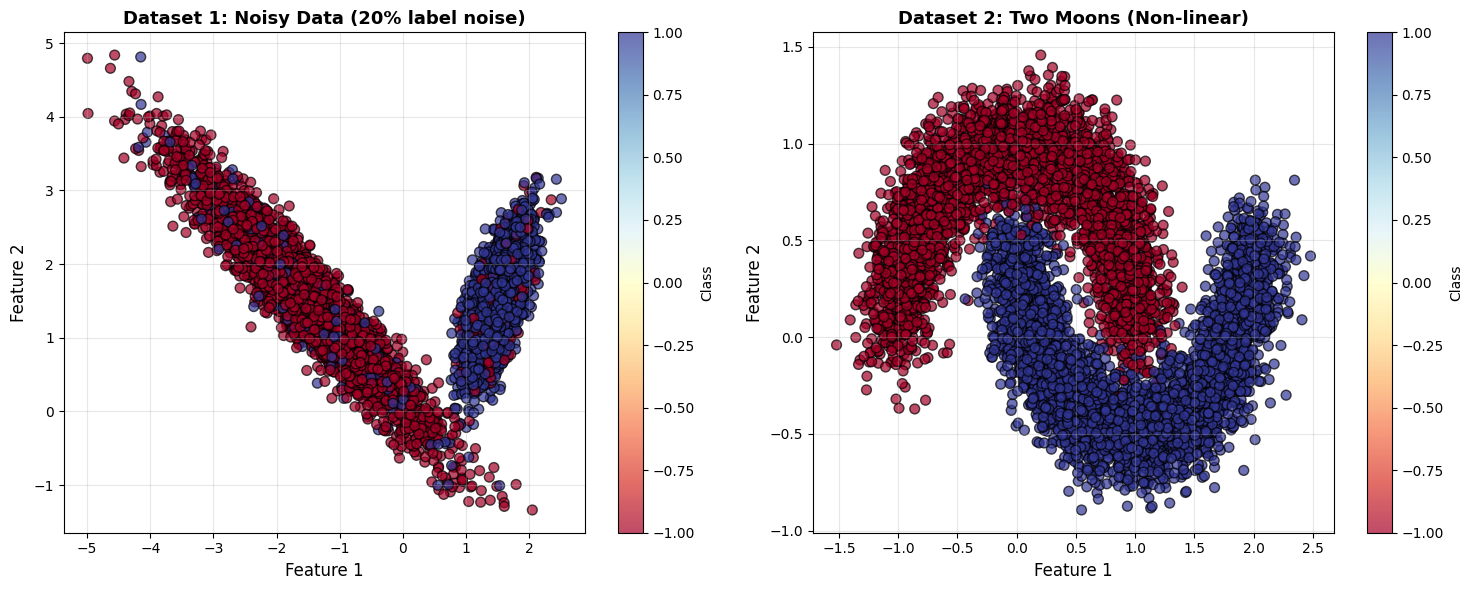

In [98]:
# Visualize data

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot noisy dataset
scatter1 = axes[0].scatter(X_noisy_train[:, 0], X_noisy_train[:, 1], 
                           c=y_noisy_train, cmap='RdYlBu',
                           edgecolors='black', alpha=0.7, s=50)
axes[0].set_xlabel('Feature 1', fontsize=12)
axes[0].set_ylabel('Feature 2', fontsize=12)
axes[0].set_title('Dataset 1: Noisy Data (20% label noise)', 
                  fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=axes[0], label='Class')

# Plot moons dataset
scatter2 = axes[1].scatter(X_moons_train[:, 0], X_moons_train[:, 1], 
                           c=y_moons_train, cmap='RdYlBu',
                           edgecolors='black', alpha=0.7, s=50)
axes[1].set_xlabel('Feature 1', fontsize=12)
axes[1].set_ylabel('Feature 2', fontsize=12)
axes[1].set_title('Dataset 2: Two Moons (Non-linear)', 
                  fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=axes[1], label='Class')

plt.tight_layout()
plt.show()

# Test algorithms
## Multi-Algorithm Comparison

### Models to Test:

1. **Custom AdaBoost**: Our implementation with decision stumps
2. **Sklearn AdaBoost**: Library implementation with default real AdaBoost (SAMME.R) and decision stumps as base learners
3. **Gradient Boosting**: Another boosting method that minimizes loss through gradient descent
4. **Logistic Regression**: Simple baseline linear model

### Why These Models:

- **AdaBoost variants**: Direct comparison of our implementation
- **Gradient Boosting**: Different boosting approach
  - Uses gradient descent instead of weight updates
  - Minimizes differentiable loss function
  - Generally more robust to noise
- **Logistic Regression**: Baseline to show improvement from boosting

### Evaluation Strategy:

For each dataset:
1. Train all models
2. Compare test accuracy
3. Visualize decision boundaries
4. Analyze training curves where applicable

### Expected Results:

**Noisy Dataset**:
- Gradient Boosting should be more robust than AdaBoost
- AdaBoost may overfit on noisy points
- Logistic Regression provides stable baseline

**Moons Dataset**:
- All boosting methods should outperform Logistic Regression
- Gradient Boosting and AdaBoost should perform similarly
- Shows that ensembles can learn non-linear boundaries

In [99]:
# Set up models

def train_and_evaluate_models(X_train, X_test, y_train, y_test, dataset_name):
    """Train all models and return results."""
    
    # Initialize models
    models = {
        'Custom AdaBoost': AdaBoostCustom(T=50),
        'Sklearn AdaBoost': AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=50,
            max_depth=1,
            learning_rate=1.0,
            random_state=42
        ),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
    }
    
    results = {}
    
    print(f"\n{'='*60}")
    print(f"Training models on {dataset_name}")
    print(f"{'='*60}\n")
    
    for name, model in models.items():
        print(f"Training {name}...", end=" ")
        
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions (all models work with {-1, +1} labels)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracies
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        
        results[name] = {
            'model': model,
            'train_acc': train_acc,
            'test_acc': test_acc,
            'is_custom': (name == 'Custom AdaBoost')
        }
        
        print(f"Done! Train: {train_acc:.4f}, Test: {test_acc:.4f}")
    
    return results

print("Model setup complete!") 

Model setup complete!



Training models on Noisy Dataset

Training Custom AdaBoost... Done! Train: 0.8977, Test: 0.8893
Training Sklearn AdaBoost... Done! Train: 0.8977, Test: 0.8893
Training Gradient Boosting... Done! Train: 0.9016, Test: 0.8940
Training Logistic Regression... Done! Train: 0.9013, Test: 0.8960

Training models on Two Moons Dataset

Training Custom AdaBoost... Done! Train: 0.9923, Test: 0.9930
Training Sklearn AdaBoost... Done! Train: 0.9923, Test: 0.9930
Training Gradient Boosting... Done! Train: 0.9934, Test: 0.9913
Training Logistic Regression... Done! Train: 0.8807, Test: 0.8783


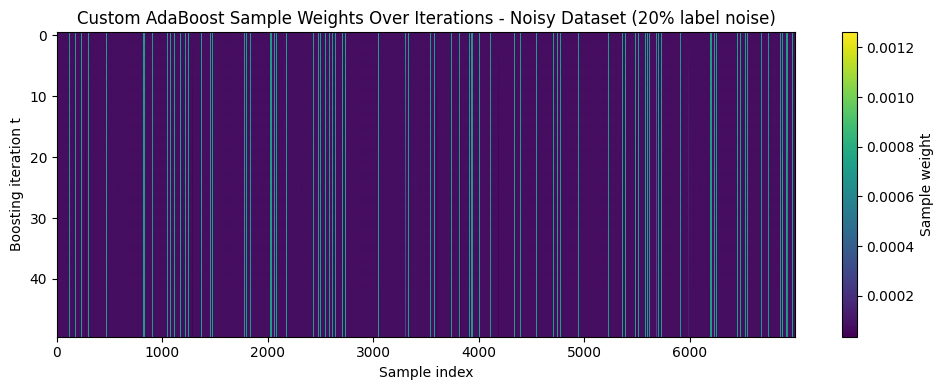

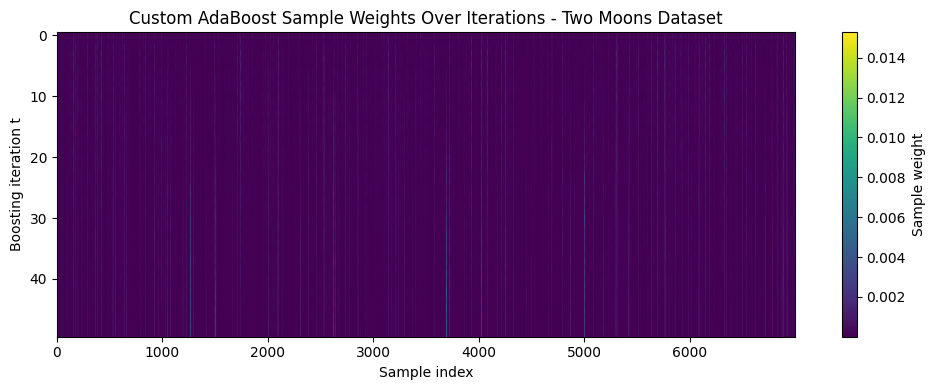

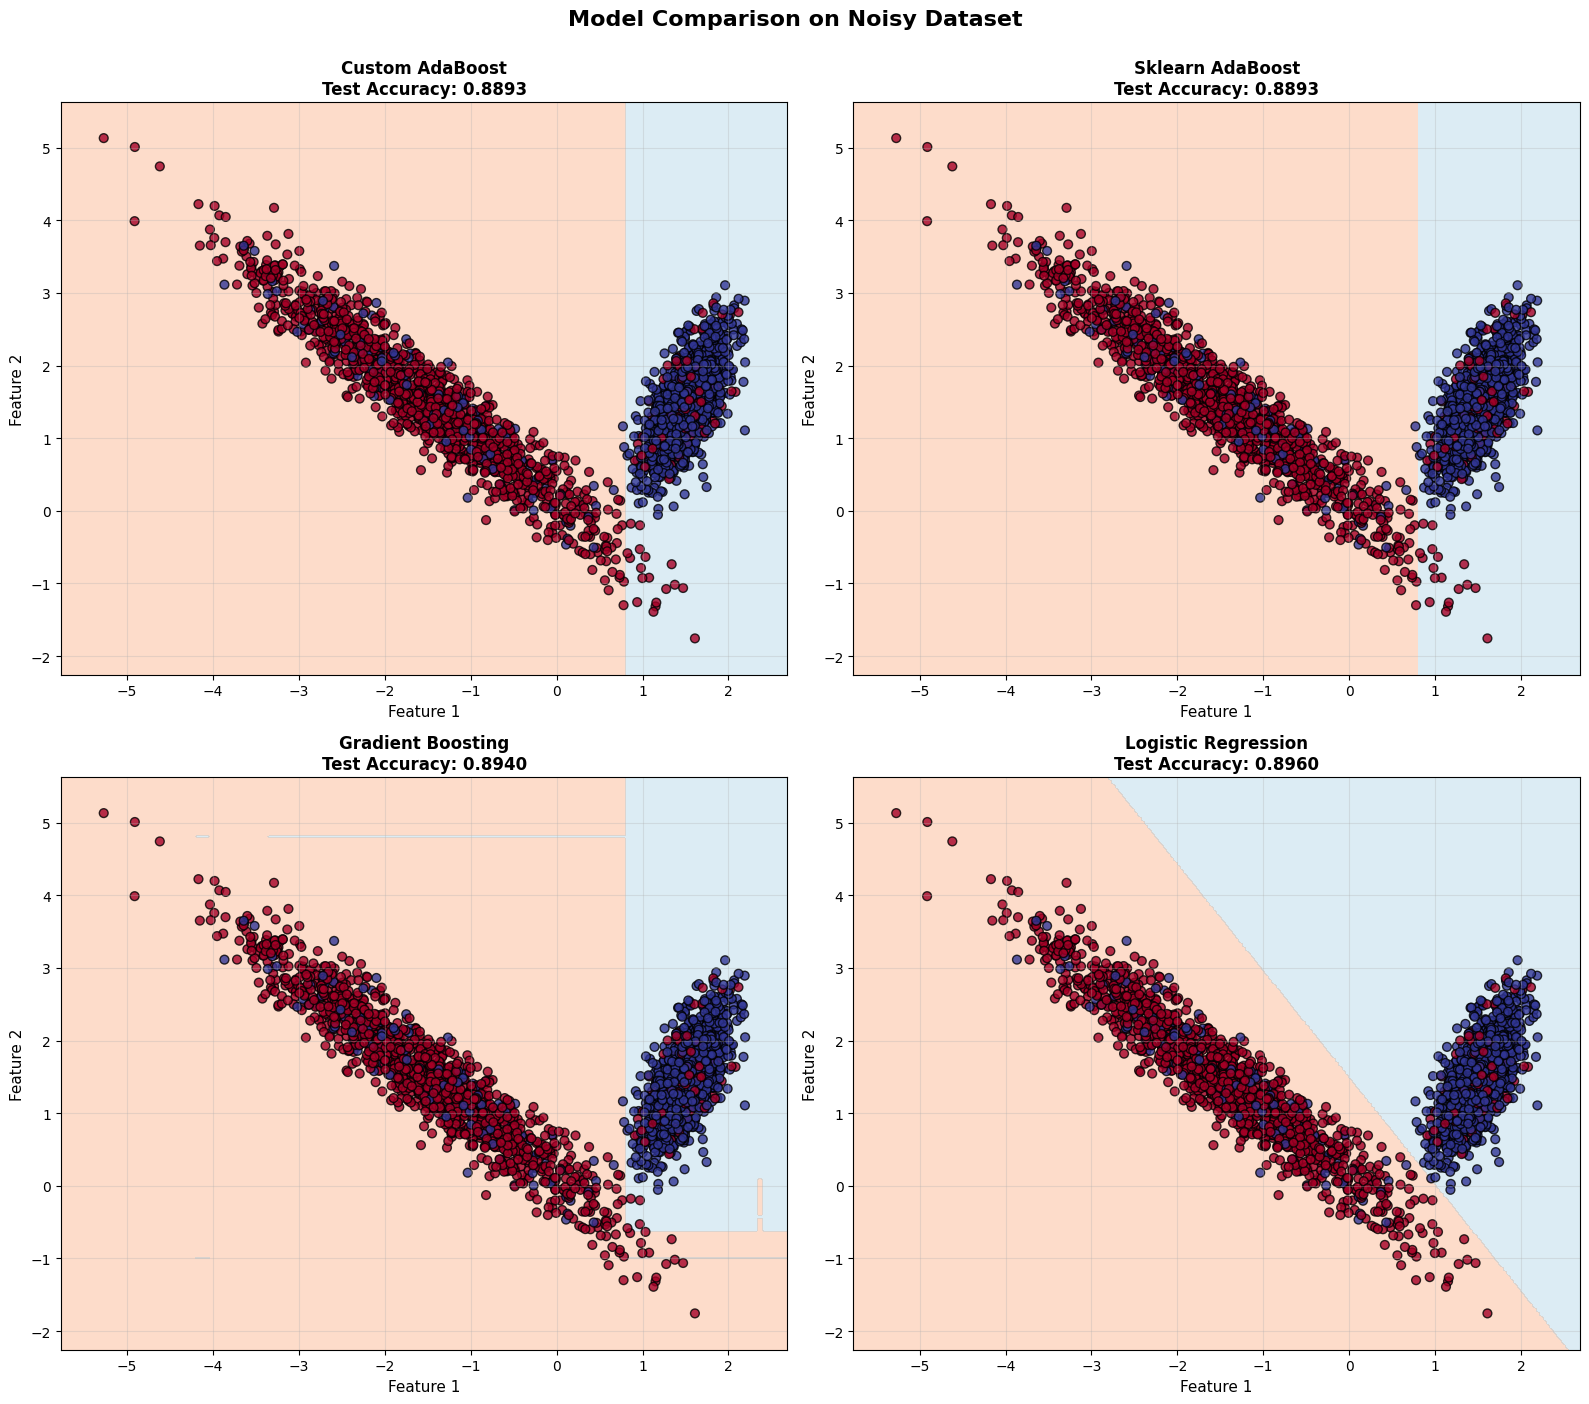

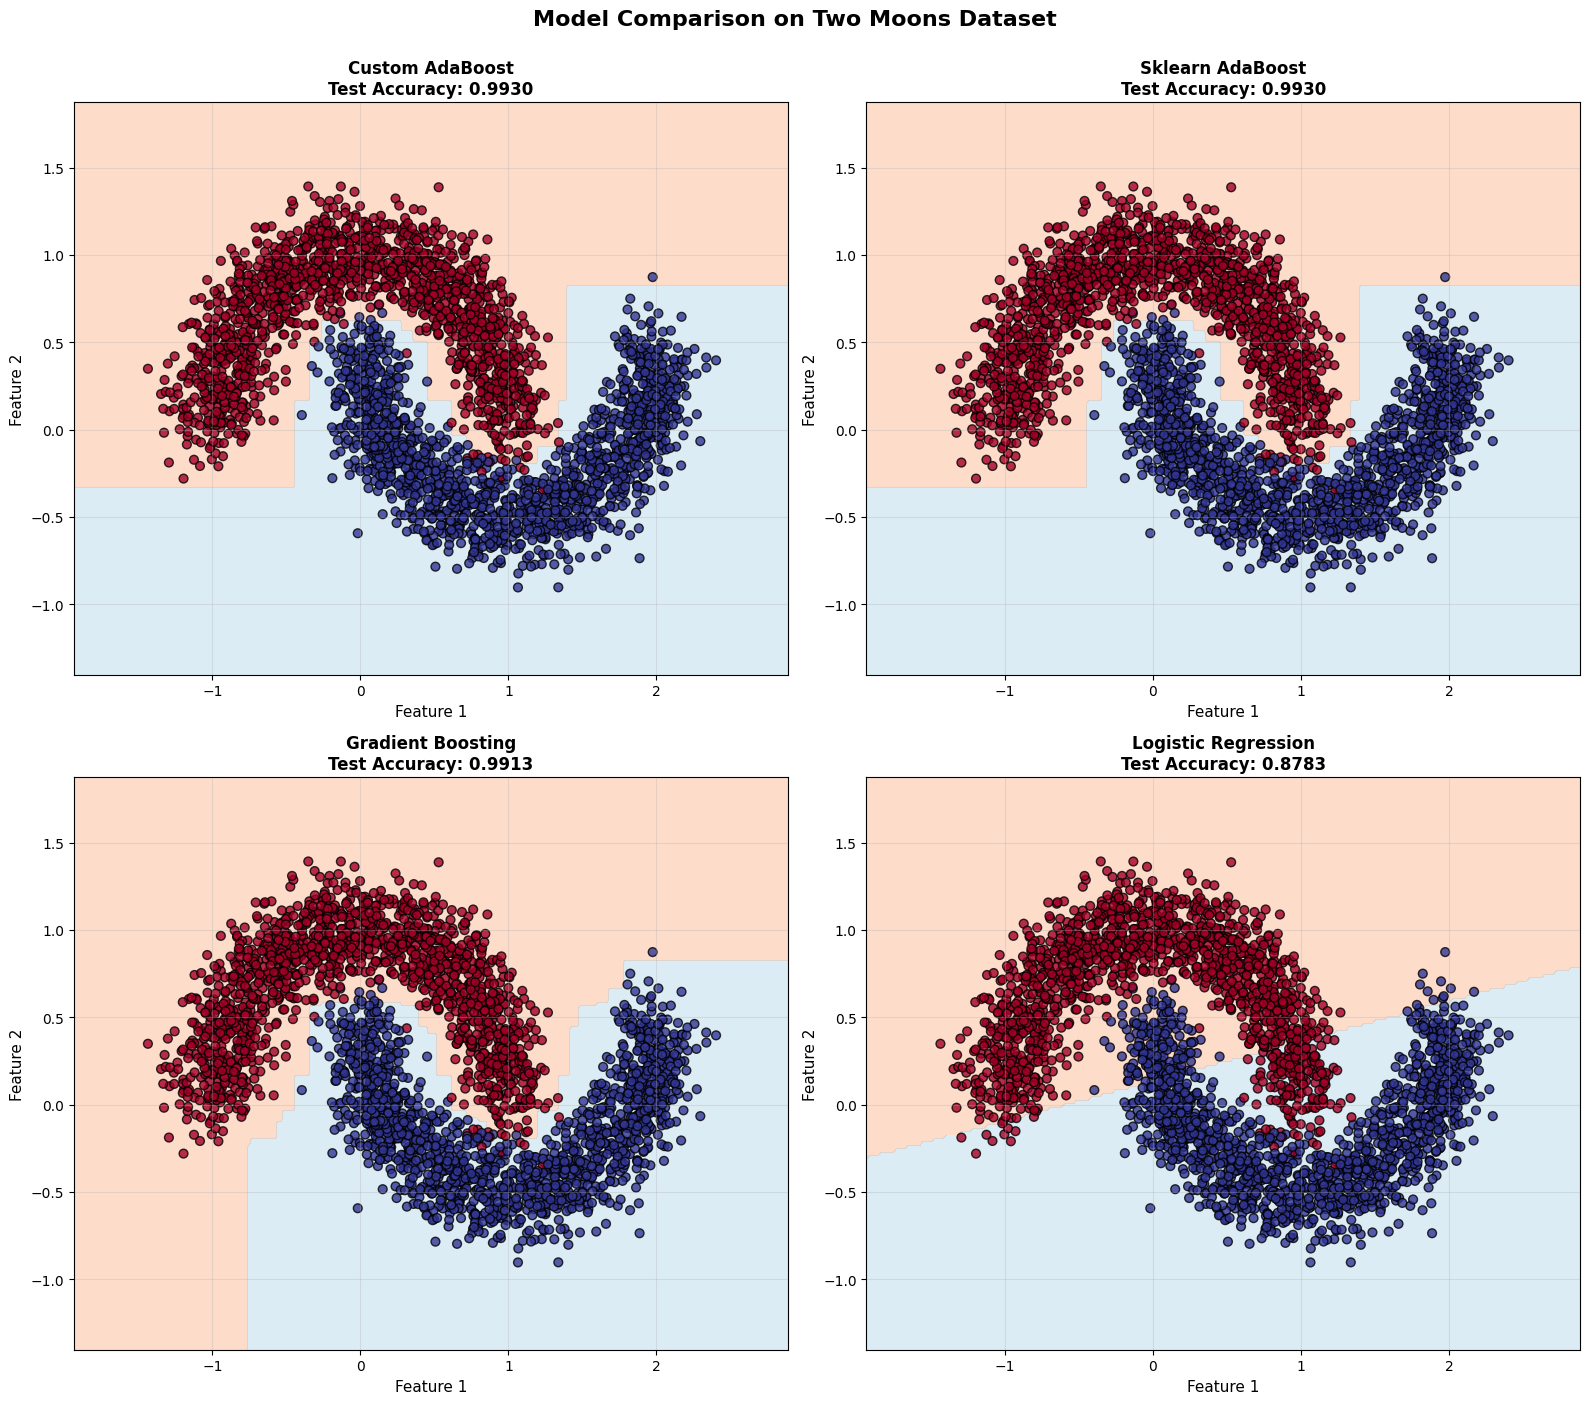

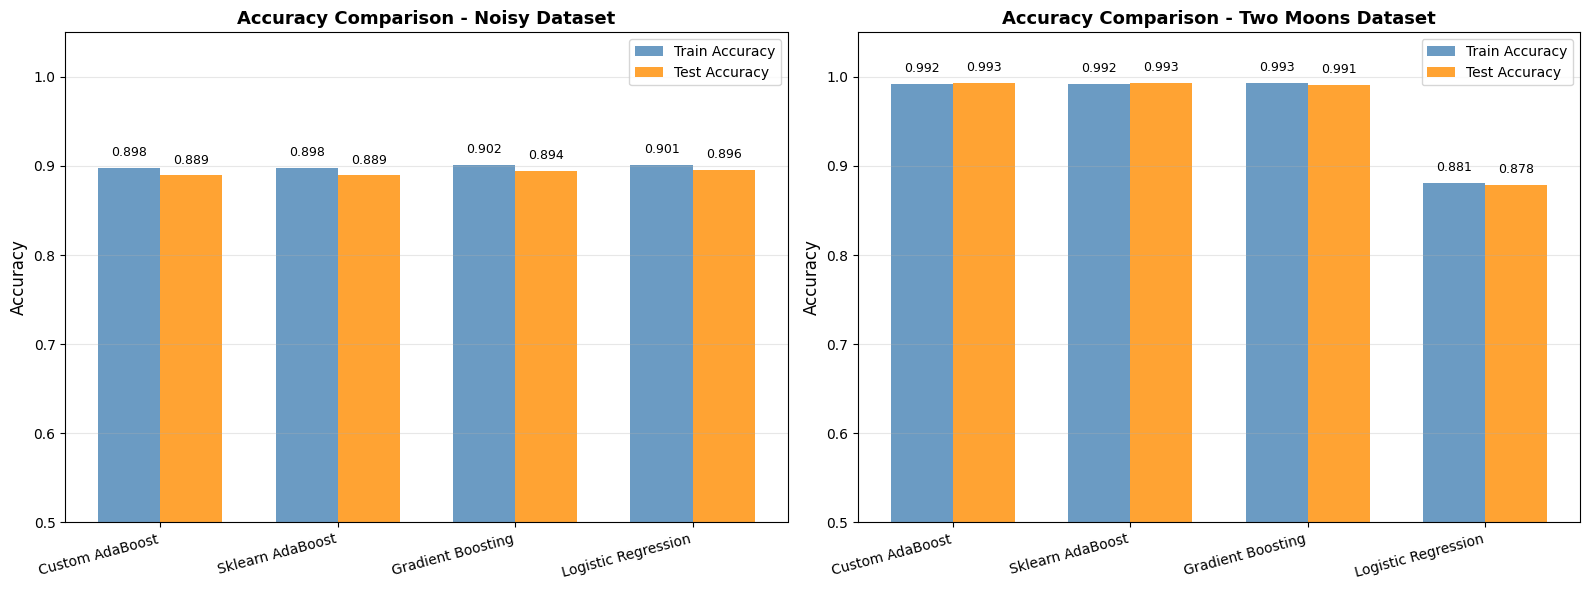


ANALYSIS SUMMARY

### Noisy Dataset Results:
--------------------------------------------------------------------------------
Custom AdaBoost           | Train: 0.8977 | Test: 0.8893 | Overfit: 0.0084
Sklearn AdaBoost          | Train: 0.8977 | Test: 0.8893 | Overfit: 0.0084
Gradient Boosting         | Train: 0.9016 | Test: 0.8940 | Overfit: 0.0076
Logistic Regression       | Train: 0.9013 | Test: 0.8960 | Overfit: 0.0053

### Two Moons Dataset Results:
--------------------------------------------------------------------------------
Custom AdaBoost           | Train: 0.9923 | Test: 0.9930 | Overfit: -0.0007
Sklearn AdaBoost          | Train: 0.9923 | Test: 0.9930 | Overfit: -0.0007
Gradient Boosting         | Train: 0.9934 | Test: 0.9913 | Overfit: 0.0021
Logistic Regression       | Train: 0.8807 | Test: 0.8783 | Overfit: 0.0024


In [100]:
# Test and visualize

# Train models on both datasets
results_noisy = train_and_evaluate_models(
    X_noisy_train, X_noisy_test, y_noisy_train, y_noisy_test, 
    "Noisy Dataset"
)

results_moons = train_and_evaluate_models(
    X_moons_train, X_moons_test, y_moons_train, y_moons_test, 
    "Two Moons Dataset"
)

# Helper to plot weight heatmap for a dataset from the results dict
def plot_weight_heatmap_from_results(results, dataset_name):
    custom_model = results['Custom AdaBoost']['model']
    
    # Stack per-iteration weights: shape (T_used, n_train_samples)
    W = np.stack(custom_model.weights_history)
    
    plt.figure(figsize=(10, 4))
    plt.imshow(W, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Sample weight')
    plt.xlabel('Sample index')
    plt.ylabel('Boosting iteration t')
    plt.title(f'Custom AdaBoost Sample Weights Over Iterations - {dataset_name}')
    plt.tight_layout()
    plt.show()

# Plot for noisy dataset (20% label noise)
plot_weight_heatmap_from_results(results_noisy, 'Noisy Dataset (20% label noise)')

# Plot for Two Moons dataset (with noise=0.15 in features)
plot_weight_heatmap_from_results(results_moons, 'Two Moons Dataset')

# Visualization function for decision boundaries
def plot_comparison_grid(X_test, y_test, results, title):
    """Plot decision boundaries for all models in a grid."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.ravel()
    
    model_names = list(results.keys())
    
    for idx, name in enumerate(model_names):
        model = results[name]['model']
        test_acc = results[name]['test_acc']
        is_custom = results[name]['is_custom']
        
        # Create mesh
        h = 0.02
        x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
        y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        # Predict on mesh (all models output {-1, +1})
        mesh_points = np.c_[xx.ravel(), yy.ravel()]
        Z = model.predict(mesh_points)
        Z = Z.reshape(xx.shape)
        
        # Plot (contourf works with any numeric values)
        axes[idx].contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu', levels=[-1.5, 0, 1.5])
        axes[idx].scatter(X_test[:, 0], X_test[:, 1], c=y_test, 
                         cmap='RdYlBu', edgecolors='black', s=40, alpha=0.8)
        axes[idx].set_xlabel('Feature 1', fontsize=11)
        axes[idx].set_ylabel('Feature 2', fontsize=11)
        axes[idx].set_title(f'{name}\nTest Accuracy: {test_acc:.4f}', 
                           fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
    
    fig.suptitle(title, fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

# Plot decision boundaries for both datasets
plot_comparison_grid(X_noisy_test, y_noisy_test, results_noisy, 
                    'Model Comparison on Noisy Dataset')

plot_comparison_grid(X_moons_test, y_moons_test, results_moons, 
                    'Model Comparison on Two Moons Dataset')

# Comparative bar charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

datasets = ['Noisy Dataset', 'Two Moons Dataset']
results_list = [results_noisy, results_moons]

for idx, (dataset_name, results) in enumerate(zip(datasets, results_list)):
    model_names = list(results.keys())
    test_accs = [results[name]['test_acc'] for name in model_names]
    train_accs = [results[name]['train_acc'] for name in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = axes[idx].bar(x - width/2, train_accs, width, 
                          label='Train Accuracy', alpha=0.8, color='steelblue')
    bars2 = axes[idx].bar(x + width/2, test_accs, width, 
                          label='Test Accuracy', alpha=0.8, color='darkorange')
    
    axes[idx].set_ylabel('Accuracy', fontsize=12)
    axes[idx].set_title(f'Accuracy Comparison - {dataset_name}', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(model_names, rotation=15, ha='right')
    axes[idx].legend(fontsize=10)
    axes[idx].set_ylim([0.5, 1.05])
    axes[idx].grid(True, axis='y', alpha=0.3)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Analysis summary
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print("\n### Noisy Dataset Results:")
print("-" * 80)
for name, res in results_noisy.items():
    overfitting = res['train_acc'] - res['test_acc']
    print(f"{name:25s} | Train: {res['train_acc']:.4f} | Test: {res['test_acc']:.4f} | Overfit: {overfitting:.4f}")

print("\n### Two Moons Dataset Results:")
print("-" * 80)
for name, res in results_moons.items():
    overfitting = res['train_acc'] - res['test_acc']
    print(f"{name:25s} | Train: {res['train_acc']:.4f} | Test: {res['test_acc']:.4f} | Overfit: {overfitting:.4f}")

## Analysis Summary
1. NOISY DATASET:
   - The weight evolution plots clearly show that AdaBoost repeatedly increases the weights of mislabeled samples, causing many points to dominate the training process. This confirms AdaBoost’s sensitivity to label noise.
   - The divergence between training error and test error demonstrates AdaBoost overfitting on noisy labels.
   - Gradient Boosting, with its focus on reducing loss rather than correcting misclassifications, is less affected by noisy labels.
   - Logistic Regression provides a stable baseline that does not overfit noisy samples.
   
2. TWO MOONS DATASET:
   - The weight distribution heatmap shows many moderately weighted samples along the curved decision boundary, reflecting the difficulty of approximating a non linear shape with decision stumps.
   - Unlike in the noisy dataset, no individual sample accumulates extreme weight, indicating that the algorithm is focusing on genuinely ambiguous boundary points rather than mislabeled ones.
   - Both the custom and sklearn AdaBoost implementations exhibit smooth and stable weight evolution, validating the correctness of the custom algorithm.
   - Logistic Regression struggles with non linearity, while boosting methods successfully learn the curved boundary.

3. GENERAL INSIGHTS:
   - The experiments illustrate that boosting is most effective when errors are systematic (like a curvature in two moons) rather than random (label noise).
   - The results emphasize the importance of model selection: powerful ensemble methods can capture complex patterns but must be used with care when noise or mislabeled samples are present.
   - Boosting methods build complex classifiers from simple stumps, achieving strong performance even on challenging non linear datasets.
   - Trade off exists between fitting power and robustness to noise.
   - Ensemble methods significantly outperform single models on complex data.

# Use of generative AI
## Use of Generative AI in This Assignment

### How We Used AI Assistance:

1. **Algorithm Review**: 
   - Used AI to review AdaBoost mathematical formulations
   - Verified our understanding of the algorithm steps
   - Clarified differences between AdaBoost variants (SAMME, SAMME.R)

2. **Code Structure**:
   - Consulted for best practices in implementing decision stumps
   - Got suggestions for vectorized operations in NumPy
   - Reviewed efficient mesh generation for decision boundary plots

3. **Debugging**:
   - Used AI to help identify issues with weight normalization
   - Got guidance on handling edge cases (error >= 0.5)
   - Clarified label conversion between {0,1} and {-1,+1}

4. **Visualization**:
   - Generated code for graphs we wanted to plot

5. **Documentation**:
   - Used AI to help structure markdown explanations
   - Improved clarity of mathematical notations
   - Enhanced comments in code

### What We Did NOT Use AI For:

- Core algorithm logic (implemented from scratch based on theory)
- Experimental design (chose datasets and comparisons independently)
- Analysis and interpretation of results (our own observations)
- Critical thinking about strengths/weaknesses

### Attribution:

All code is our own implementation. AI was used as a learning tool and for improving code quality, similar to consulting documentation or textbooks. The mathematical understanding, experimental design, and analysis are entirely our own work.

### Learning Outcome:

Using AI as a tutor helped us:
- Better understand NumPy vectorization
- Learn professional coding practices
- Improve our technical communication
- Debug more efficiently

We maintained intellectual honesty by ensuring we understood every line of code and could explain all concepts without AI assistance. 